In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
from datetime import datetime
from regions import PolygonSkyRegion

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


In [2]:
eui_map = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

In [3]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [5]:
chase_halpha_line_width_map = sunpy.map.Map("../../src/CHASE/20221024/RSM20221024T191230_0022_HA_linewidth.fits")
chase_halpha_line_width_map.meta["rsun_ref"] = 696000000.0
chase_halpha_line_width_map.plot_settings['cmap'] = "plasma"
chase_halpha_line_width_map.plot_settings['norm'] = ImageNormalize(vmin=0.9,vmax=1.35)

In [6]:
Txshift_chase_aia, Tyshift_chase_aia = 0.143954*u.arcsec, 1.06003*u.arcsec

In [7]:
chase_halpha_line_width_map_align = chase_halpha_line_width_map.submap(SkyCoord(-550*u.arcsec,100*u.arcsec,frame=chase_halpha_line_width_map.coordinate_frame),
                                                                top_right=SkyCoord(-250*u.arcsec,400*u.arcsec,frame=chase_halpha_line_width_map.coordinate_frame))
chase_halpha_line_width_map_align_shift = chase_halpha_line_width_map_align.shift_reference_coord(Txshift_chase_aia,Tyshift_chase_aia)

In [8]:
chase_halpha_doppler_map_align_shift = sunpy.map.Map("../../src/coalign_map/20221024/chase_halpha_doppler_map.fits")

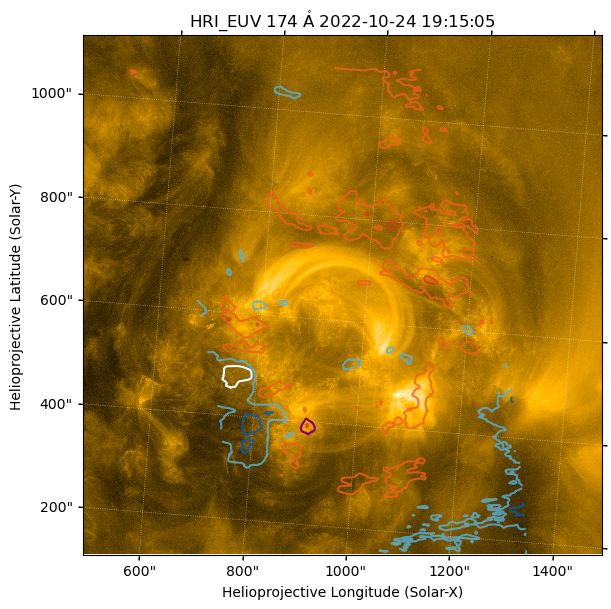

In [9]:
fig = plt.figure(figsize=(6,6),layout="constrained")

ax = fig.add_subplot(111,projection=eui_map.wcs)

eui_map.plot(axes=ax)

cs = eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax,alpha=0.8)
cs_index = 6
cs_downflow_index = 7
ax.plot(cs.allsegs[0][cs_index][:,0],cs.allsegs[0][cs_index][:,1],color="white")
ax.plot(cs.allsegs[2][cs_downflow_index][:,0],cs.allsegs[2][cs_downflow_index][:,1],color="purple")

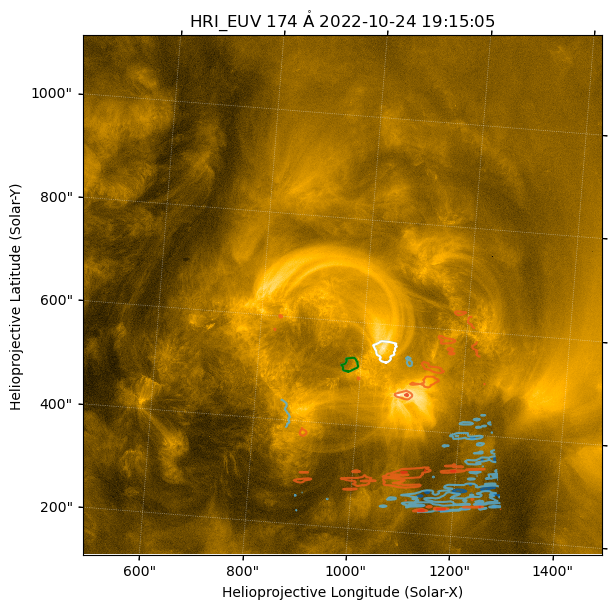

In [10]:
fig = plt.figure(figsize=(6,6),layout="constrained")

ax = fig.add_subplot(111,projection=eui_map.wcs)

eui_map.plot(axes=ax)

cs_hh = eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax,alpha=0.8)
cs_hh_index = 43
cs_hh_index_2 = 41
ax.plot(cs_hh.allsegs[1][cs_hh_index][:,0],cs_hh.allsegs[1][cs_hh_index][:,1],color="white")
ax.plot(cs_hh.allsegs[1][cs_hh_index_2][:,0],cs_hh.allsegs[1][cs_hh_index_2][:,1],color="green")

In [11]:
cs_skycoord_east_1 = eui_map.pixel_to_world(cs.allsegs[0][cs_index][:-1,0]*u.pix,cs.allsegs[0][cs_index][:-1,1]*u.pix)
region_east_1 = PolygonSkyRegion(vertices=cs_skycoord_east_1)

cs_skycoord_center_1 = eui_map.pixel_to_world(cs_hh.allsegs[1][cs_hh_index][:-1,0]*u.pix,cs_hh.allsegs[1][cs_hh_index][:-1,1]*u.pix)
region_center_1 = PolygonSkyRegion(vertices=cs_skycoord_center_1)

cs_skycoord_center_2 = eui_map.pixel_to_world(cs_hh.allsegs[1][cs_hh_index_2][:-1,0]*u.pix,cs_hh.allsegs[1][cs_hh_index_2][:-1,1]*u.pix)
region_center_2 = PolygonSkyRegion(vertices=cs_skycoord_center_2)

cs_skycoord_moss = eui_map.pixel_to_world(cs.allsegs[2][cs_downflow_index][:-1,0]*u.pix,cs.allsegs[2][cs_downflow_index][:-1,1]*u.pix)
region_moss = PolygonSkyRegion(vertices=cs_skycoord_moss)

In [17]:
chase_map_all_coords = sunpy.map.all_coordinates_from_map(chase_halpha_doppler_map_align_shift)
with propagate_with_solar_surface(rotation_model="rigid"):
    chase_map_all_coords_to_hri = chase_map_all_coords.transform_to(eui_map.coordinate_frame)

chase_mask_east_1 = np.where(region_east_1.contains(chase_map_all_coords_to_hri,eui_map.wcs))
chase_mask_center_1 = np.where(region_center_1.contains(chase_map_all_coords_to_hri,eui_map.wcs))
chase_mask_center_2 = np.where(region_center_2.contains(chase_map_all_coords_to_hri,eui_map.wcs))
chase_mask_moss = np.where(region_moss.contains(chase_map_all_coords_to_hri,eui_map.wcs))

In [18]:
chase_halpha_line_width_east_1 = chase_halpha_line_width_map_align_shift.data[chase_mask_east_1]
chase_halpha_line_width_center_1 = chase_halpha_line_width_map_align_shift.data[chase_mask_center_1]
chase_halpha_line_width_center_2 = chase_halpha_line_width_map_align_shift.data[chase_mask_center_2]
chase_halpha_line_width_moss = chase_halpha_line_width_map_align_shift.data[chase_mask_moss]

chase_halpha_doppler_east_1 = chase_halpha_doppler_map_align_shift.data[chase_mask_east_1]
chase_halpha_doppler_center_1 = chase_halpha_doppler_map_align_shift.data[chase_mask_center_1]
chase_halpha_doppler_center_2 = chase_halpha_doppler_map_align_shift.data[chase_mask_center_2]
chase_halpha_doppler_moss = chase_halpha_doppler_map_align_shift.data[chase_mask_moss]

In [20]:
eui_map_crop = eui_map.submap([500,350]*u.pix,top_right=[1500,1350]*u.pix)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00469484, 0.        , 0.00469484,
        0.00938967, 0.01877934, 0.02347418, 0.02816901, 0.03755869,
        0.04225352, 0.06103286, 0.11737089, 0.15023474, 0.16901408,
        0.10328638, 0.1314554 , 0.05164319, 0.04694836, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.9       , 0.91285714, 0.92571429, 0.93857143, 0.95142857,
        0.96428571, 0.97714286, 0.99      , 1.00285714, 1.01571429,
        1.02857143, 1.04142857, 1.05428571, 1.06714286, 1.08      ,
        1.09285714, 1.10571429, 1.11857143, 1.13142857, 1.14428571,
        1.15714286, 1.17      , 1.18285714, 1.19571429, 1.20857143,
        1.22142857, 1.23428571, 1.24714286, 1.26      , 1.27285714,
        1.28571429, 1.29857143, 1.31142857, 1.32428571, 1.33714286,
        1.35      ]),
 [<matplotlib.patches.Po

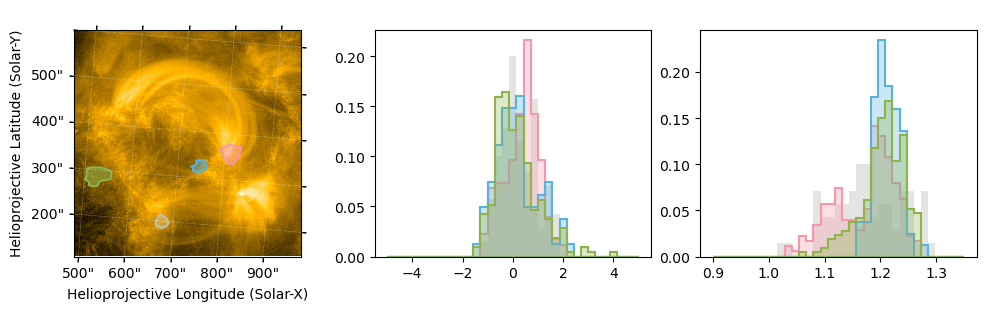

In [33]:
fig = plt.figure(figsize=(10,3),layout="constrained")

ax1 = fig.add_subplot(131,projection=eui_map.wcs)

eui_map_crop.plot(axes=ax1)
region_center_1.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(245./255,150./255,170./255,0.5),fill=True,
                                                edgecolor=(245./255,150./255,170./255,1),lw=1.5,label="C1")
region_center_2.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(88./255,178./255,220./255,0.5),fill=True,
                                                edgecolor=(88./255,178./255,220./255,1),lw=1.5,label="C2")
region_moss.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(189./255,192./255,186./255,0.3),fill=True,
                                                edgecolor=(189./255,192./255,186./255,1),lw=1.5,label="Moss")
region_east_1.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(140./255,180./255,75./255,0.5),fill=True,
                                                edgecolor=(140./255,180./255,75./255,1),lw=1.5,label="E1")
ax1.set_title(" ")

ax2 = fig.add_subplot(132)

ax2.hist(chase_halpha_doppler_moss,bins=35,range=(-5,5),facecolor=(189./255,192./255,186./255,0.4),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",weights=np.ones_like(chase_halpha_doppler_moss)/len(chase_halpha_doppler_moss))
ax2.hist(chase_halpha_doppler_center_1,bins=35,range=(-5,5),facecolor=(245./255,150./255,170./255,0.3),label="C1",lw=1.5,
        ls="-",histtype="stepfilled",edgecolor=(245./255,150./255,170./255,1),
        weights=np.ones_like(chase_halpha_doppler_center_1)/len(chase_halpha_doppler_center_1))
ax2.hist(chase_halpha_doppler_center_2,bins=35,range=(-5,5),facecolor=(88./255,178./255,220./255,0.3),label="C2",lw=1.5,
        ls="-",histtype="stepfilled",edgecolor=(88./255,178./255,220./255,1),
        weights=np.ones_like(chase_halpha_doppler_center_2)/len(chase_halpha_doppler_center_2))
ax2.hist(chase_halpha_doppler_east_1,bins=35,range=(-5,5),facecolor=(140./255,180./255,75./255,0.3),label="E1",lw=1.5,
        ls="-",histtype="stepfilled",edgecolor=(140./255,180./255,75./255,1),
        weights=np.ones_like(chase_halpha_doppler_east_1)/len(chase_halpha_doppler_east_1))

ax3 = fig.add_subplot(133)

ax3.hist(chase_halpha_line_width_moss,bins=35,range=(0.9,1.35),facecolor=(189./255,192./255,186./255,0.4),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",weights=np.ones_like(chase_halpha_line_width_moss)/len(chase_halpha_line_width_moss))
ax3.hist(chase_halpha_line_width_center_1,bins=35,range=(0.9,1.35),facecolor=(245./255,150./255,170./255,0.3),label="C1",lw=1.5,
        ls="-",histtype="stepfilled",edgecolor=(245./255,150./255,170./255,1),
        weights=np.ones_like(chase_halpha_line_width_center_1)/len(chase_halpha_line_width_center_1))
ax3.hist(chase_halpha_line_width_center_2,bins=35,range=(0.9,1.35),facecolor=(88./255,178./255,220./255,0.3),label="C2",lw=1.5,
        ls="-",histtype="stepfilled",edgecolor=(88./255,178./255,220./255,1),
        weights=np.ones_like(chase_halpha_line_width_center_2)/len(chase_halpha_line_width_center_2))
ax3.hist(chase_halpha_line_width_east_1,bins=35,range=(0.9,1.35),facecolor=(140./255,180./255,75./255,0.3),label="E1",lw=1.5,
        ls="-",histtype="stepfilled",edgecolor=(140./255,180./255,75./255,1),
        weights=np.ones_like(chase_halpha_line_width_east_1)/len(chase_halpha_line_width_east_1))